In [19]:
import ContexualEnvs
import numpy as np
import matplotlib.pyplot as plt

## Compare different Policy

In [20]:
class Policy:
    def select(self, x:np.ndarray) -> int: raise NotImplementedError()
    def update(self, arm:int, x: np.ndarray, r: int): pass

class RandomPolicy(Policy):
    def __init__(self, k, seed=0):
        self.k = k
        self.rng = np.random.default_rng(seed)
    def select(self, x): return int(self.rng.integers(0, self.k))

class ContextualEpsGreedy(Policy):
    def __init__(self, k, d, epsilon=0.1, seed=0):
        self.eps = float(epsilon)
        self.Q = np.zeros((k, d))
        self.N = np.zeros(k, dtype = int)
        self.rng = np.random.default_rng(seed)
    def select(self, x):
        if self.rng.random() < self.eps:
            return int(self.rng.integers(0, self.Q.shape[0]))
        scores = self.Q @ x
        best = np.flatnonzero(scores == np.max(scores))
        return int(self.rng.choice(best))
    def update(self, arm, x, r):
        self.N[arm] += 1
        pred = self.Q[arm] @ x
        self.Q[arm] += (r - pred) / self.N[arm]

class LinUCB(Policy):
    def __init__(self, k, d, alpha=1.0, lambda_=1.0):
        self.k, self.d = k, d
        self.alpha = float(alpha)
        self.A = [lambda_ * np.eye(d) for _ in range(k)]
        self.b = [np.zeros(d) for _ in range(k)]
    def select(self, x):
        vals = np.empty(self.k)
        for a in range(self.k):
            A_inv_x = np.linalg.solve(self.A[a], x) # A_inv_x = invese(lambda_ * I + X.T @ X) @ x
            theta_hat = np.linalg.solve(self.A[a], self.b[a]) # theta_hat = A_inv @ b
            pred = theta_hat @ x
            bonus = self.alpha * np.sqrt(x @ A_inv_x) # upper confidence bound
            vals[a] = pred + bonus
        return int(np.argmax(vals))
    def update(self, arm, x, r):
        self.A[arm] += np.outer(x, x) # A = λI + Σ(x_t x_t^T)
        self.b[arm] += r * x # b = Σ r_t x_t

class LinTS(Policy):
    """Linear Thompson Sampling"""
    def __init__(self, k, d, alpha=1.0, lambda_=1.0, seed=0):
        self.k, self.d = k, d
        self.alpha = float(alpha)
        self.A = [lambda_ * np.eye(d) for _ in range(k)]
        self.b = [np.zeros(d) for _ in range(k)]
        self.rng = np.random.default_rng()
    def select(self, x):
        vals = np.empty(self.k)
        for a in range(self.k):
            A_inv = np.linalg.inv(self.A[a])
            mu = A_inv @ self.b[a]
            """sample theta_post from mvtnorm(mu, alpha^2 * A_inv)"""
            theta_post = self.rng.multivariate_normal(mu, self.alpha**2 * A_inv)
            vals[a] = theta_post @ x
        return int(np.argmax(vals))
    def update(self, arm, x, r):
        self.A[arm] += np.outer(x, x)
        self.b[arm] += r * x

class LogisticUCB(Policy):
    """Logistic UCB"""
    def __init__(self, k, d, alpha=1.0, lambda_=1.0, seed=0):
        self.k, self.d = k, d
        self.alpha = float(alpha)
        self.A = [lambda_ * np.eye(d) for _ in range(k)]
        self.b = [np.zeros(d) for _ in range(k)]
    def select(self, x):
        vals = np.empty(self.k)
        for a in range(self.k):
            A_inv_x = np.linalg.solve(self.A[a], x)
            theta_hat = np.linalg.solve(self.A[a], self.b[a])
            pred = 1 / (1 + np.exp(-theta_hat @ x))  # logistic function
            bonus = self.alpha * np.sqrt(x @ A_inv_x)
            vals[a] = pred + bonus
        return int(np.argmax(vals))
    def update(self, arm, x, r):
        self.A[arm] += np.outer(x, x)
        self.b[arm] += r * x



### Simulate and compare each policy

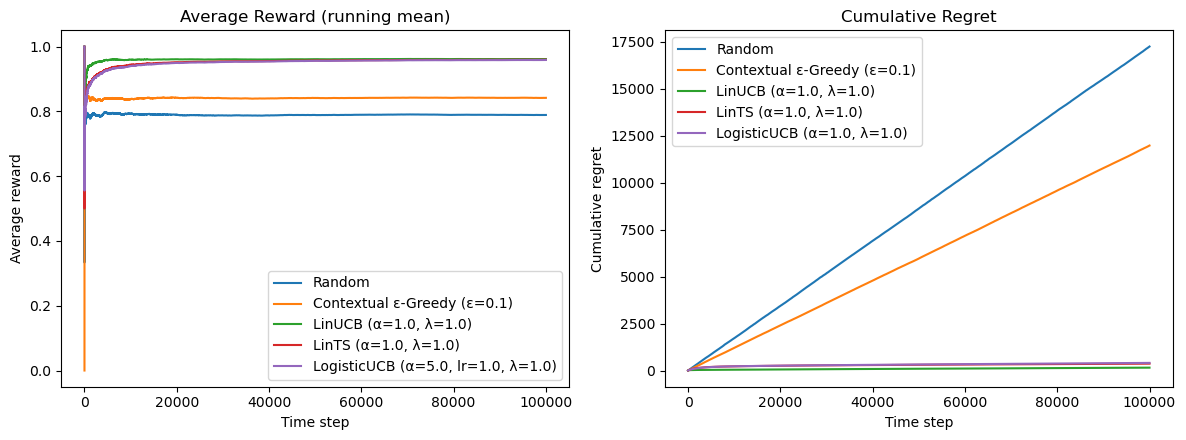

Totals over T steps
  Random:              reward=78879, final avg=0.789, cum regret=17247.0
  Contextual ε-Greedy: reward=84162, final avg=0.842, cum regret=11976.6
  LinUCB:              reward=96138, final avg=0.961, cum regret=152.7
  LinTS:               reward=95937, final avg=0.959, cum regret=365.9
  LogisticUCB:        reward=95852, final avg=0.959, cum regret=406.3


In [22]:
T = 100000         # horizon (longer run for clearer curves)
epsilon = 0.1     # contextual ε-greedy exploration rate
alpha = 1.0       # LinUCB exploration bonus
lambda_ = 1.0     # LinUCB regularization
seed = 7          # master seed for reproducibility

env_for_contexts = ContexualEnvs.ContextualNewsEnv(seed)
contexts = [env_for_contexts.sample_context() for _ in range(T)]

def run_on_contexts(policy, env_seed, contexts):
    env = ContexualEnvs.ContextualNewsEnv(seed=env_seed)
    rewards = np.zeros(len(contexts), dtype=int)
    inst_regret = np.zeros(len(contexts), dtype=float)
    for t, x in enumerate(contexts):
        arm = policy.select(x)
        r, p_sel = env.click(arm, x)
        # compute instantaneous regret in *expected* terms:
        # p*(x) - p_sel(x), where p*(x)=max_a sigmoid(θ_a · x)
        rewards[t] = r
        true_scores = env.theta @ x
        p_star = 1.0 / (1.0 + np.exp(-np.max(true_scores)))
        inst_regret[t] = p_star - p_sel
        policy.update(arm, x, r)
    return rewards, inst_regret

rng = np.random.default_rng(seed)
k = ContexualEnvs.ContextualNewsEnv(seed=seed).k
d = ContexualEnvs.ContextualNewsEnv(seed=seed).d

rewards_rand, regret_rand = run_on_contexts(RandomPolicy(k, seed=seed), seed, contexts)
rewards_eps,  regret_eps  = run_on_contexts(ContextualEpsGreedy(k, d, epsilon, seed), seed, contexts)
rewards_ucb,  regret_ucb  = run_on_contexts(LinUCB(k, d, alpha=alpha, lambda_=lambda_), seed, contexts)
rewards_ts,   regret_ts   = run_on_contexts(LinTS(k, d, alpha=alpha, lambda_=lambda_, seed=seed), seed, contexts)
rewards_logucb, regret_logucb = run_on_contexts(LogisticUCB(k, d, alpha, lambda_=1.0, seed=seed), seed, contexts)

# ---- Curves: running average reward & cumulative regret ---------------------
avg_rand = np.cumsum(rewards_rand) / np.arange(1, T+1)
avg_eps  = np.cumsum(rewards_eps)  / np.arange(1, T+1)
avg_ucb  = np.cumsum(rewards_ucb)  / np.arange(1, T+1)
avg_ts   = np.cumsum(rewards_ts)   / np.arange(1, T+1)
avg_logucb= np.cumsum(rewards_logucb)/ np.arange(1, T+1)


cumreg_rand = np.cumsum(regret_rand)
cumreg_eps  = np.cumsum(regret_eps)
cumreg_ucb  = np.cumsum(regret_ucb)
cumreg_ts   = np.cumsum(regret_ts)
cumreg_logucb= np.cumsum(regret_logucb)

# ---- Plot -------------------------------------------------------------------
plt.figure(figsize=(12,4.5))

plt.subplot(1,2,1)
plt.plot(avg_rand, label="Random")
plt.plot(avg_eps,  label=f"Contextual ε-Greedy (ε={epsilon})")
plt.plot(avg_ucb,  label=f"LinUCB (α={alpha}, λ={lambda_})")
plt.plot(avg_ts,   label=f"LinTS (α={alpha}, λ={lambda_})")
plt.plot(avg_logucb, label=f"LogisticUCB (α=5.0, lr=1.0, λ={lambda_})")
plt.title("Average Reward (running mean)")
plt.xlabel("Time step"); plt.ylabel("Average reward"); plt.legend()

plt.subplot(1,2,2)
plt.plot(cumreg_rand, label="Random")
plt.plot(cumreg_eps,  label=f"Contextual ε-Greedy (ε={epsilon})")
plt.plot(cumreg_ucb,  label=f"LinUCB (α={alpha}, λ={lambda_})")
plt.plot(cumreg_ts,   label=f"LinTS (α={alpha}, λ={lambda_})")
plt.plot(cumreg_logucb,label=f"LogisticUCB (α={alpha}, λ={lambda_})")
plt.title("Cumulative Regret")
plt.xlabel("Time step"); plt.ylabel("Cumulative regret"); plt.legend()

plt.tight_layout()
plt.show()

# ---- Quick totals ------------------------------------------------------------
print("Totals over T steps")
print(f"  Random:              reward={rewards_rand.sum():5d}, final avg={avg_rand[-1]:.3f}, cum regret={cumreg_rand[-1]:.1f}")
print(f"  Contextual ε-Greedy: reward={rewards_eps.sum():5d}, final avg={avg_eps[-1]:.3f}, cum regret={cumreg_eps[-1]:.1f}")
print(f"  LinUCB:              reward={rewards_ucb.sum():5d}, final avg={avg_ucb[-1]:.3f}, cum regret={cumreg_ucb[-1]:.1f}")
print(f"  LinTS:               reward={rewards_ts.sum():5d}, final avg={avg_ts[-1]:.3f}, cum regret={cumreg_ts[-1]:.1f}")
print(f"  LogisticUCB:        reward={rewards_logucb.sum():5d}, final avg={avg_logucb[-1]:.3f}, cum regret={cumreg_logucb[-1]:.1f}")



### Before vs After Learning

In [24]:
# Before vs After Learning from 10,000 Samples ====================
import numpy as np

# --- Helpers (pretty printing + per-step explanation) -------------------------
def _fmt_kv(names, values):
    return ", ".join(f"{n}={v:.2f}" for n, v in zip(names, values))

def _explain_step(env, policy, x, label, show_reason=True):
    arm_names = env.arm_names
    k = env.k

    # Reasoning for each policy (before selecting)
    reasoning = ""
    if show_reason:
        if isinstance(policy, ContextualEpsGreedy):
            scores = policy.Q @ x
            max_val = np.max(scores)
            best = np.flatnonzero(scores == max_val)
            reasoning = "scores: [" + ", ".join(f"{arm_names[a]}={scores[a]:.3f}" for a in range(k)) + "]"
            if len(best) > 1:
                reasoning += f" | tie among: {', '.join(arm_names[a] for a in best)}"
        elif isinstance(policy, LinUCB):
            parts = []
            for a in range(k):
                A_inv_x = np.linalg.solve(policy.A[a], x)
                theta_hat = np.linalg.solve(policy.A[a], policy.b[a])
                pred = float(theta_hat @ x)
                bonus = float(policy.alpha * np.sqrt(x @ A_inv_x))
                parts.append(f"{arm_names[a]}={pred:.3f}+{bonus:.3f}={pred+bonus:.3f}")
            reasoning = "pred+bonus=UCB: [" + ", ".join(parts) + "]"
        else:
            reasoning = "Random policy (no scoring)."

    # Select, observe, update
    arm = policy.select(x)
    r, p = env.click(arm, x)
    policy.update(arm, x, r)

    # Bayes-optimal (for teaching/inspection only)
    true_scores = env.theta @ x
    best_true = int(np.argmax(true_scores))
    p_best = 1.0 / (1.0 + np.exp(-true_scores[best_true]))

    print(f"[{label:<10}] picked={env.arm_names[arm]:10s} | p(click)={p:.2f} | "
          f"clicked? {'YES' if r==1 else 'no '} | true best={env.arm_names[best_true]} (p*={p_best:.2f})")
    if show_reason and reasoning:
        print(f"            {reasoning}")

def walkthrough_before_after_with_random(
    pre_steps=6, train_T=10000, post_steps=6,
    epsilon=0.1, alpha=1.0, lambda_=1.0, seed=7
):
    # 1) Fixed contexts for fair comparison (same for all policies & phases)
    ctx_gen = ContexualEnvs.ContextualNewsEnv(seed=seed)
    pre_contexts   = [ctx_gen.sample_context() for _ in range(pre_steps)]
    train_contexts = [ctx_gen.sample_context() for _ in range(train_T)]
    post_contexts  = [ctx_gen.sample_context() for _ in range(post_steps)]

    # 2) Independent envs (same θ, since same seed) for each policy & phase
    env_rand_pre   = ContexualEnvs.ContextualNewsEnv(seed=seed)
    env_eps_pre    = ContexualEnvs.ContextualNewsEnv(seed=seed)
    env_ucb_pre    = ContexualEnvs.ContextualNewsEnv(seed=seed)
    env_ts_pre     = ContexualEnvs.ContextualNewsEnv(seed=seed)
    env_logucb_pre = ContexualEnvs.ContextualNewsEnv(seed=seed)

    env_rand_post  = ContexualEnvs.ContextualNewsEnv(seed=seed)
    env_eps_train  = ContexualEnvs.ContextualNewsEnv(seed=seed)
    env_ucb_train  = ContexualEnvs.ContextualNewsEnv(seed=seed)
    env_ts_train   = ContexualEnvs.ContextualNewsEnv(seed=seed)
    env_logucb_train= ContexualEnvs.ContextualNewsEnv(seed=seed)
    env_eps_post   = ContexualEnvs.ContextualNewsEnv(seed=seed)
    env_ucb_post   = ContexualEnvs.ContextualNewsEnv(seed=seed)
    env_ts_post    = ContexualEnvs.ContextualNewsEnv(seed=seed)
    env_logucb_post= ContexualEnvs.ContextualNewsEnv(seed=seed)

    # 3) Policies (Random has no learning; ε-Greedy & LinUCB start from scratch)
    rand_pre  = RandomPolicy(k=env_rand_pre.k, seed=seed)
    eps       = ContextualEpsGreedy(k=env_eps_pre.k, d=env_eps_pre.d, epsilon=epsilon, seed=seed)
    ucb       = LinUCB(k=env_ucb_pre.k, d=env_ucb_pre.d, alpha=alpha, lambda_=lambda_)
    ts        = LinTS(k=env_ts_pre.k, d=env_ts_pre.d, alpha=alpha, lambda_=lambda_, seed=seed)
    logucb    = LogisticUCB(k=env_logucb_pre.k, d=env_logucb_pre.d, alpha=alpha, lambda_=lambda_, seed=seed)

    # --- BEFORE LEARNING: first N steps --------------------------------------
    print("=== BEFORE LEARNING (first 6 steps) ===")
    for t, x in enumerate(pre_contexts, 1):
        print(f"\nStep {t} context: {_fmt_kv(env_eps_pre.feature_names, x)}")
        _explain_step(env_rand_pre, rand_pre, x, label="Random")
        _explain_step(env_eps_pre,  eps,     x, label="ε-Greedy")
        _explain_step(env_ucb_pre,  ucb,     x, label="LinUCB")
        _explain_step(env_ts_pre,   ts,      x, label="LinTS")
        _explain_step(env_logucb_pre, logucb, x, label="LogisticUCB")

    # --- TRAIN: 10,000 online rounds for ε-Greedy and LinUCB -----------------
    for x in train_contexts:
        # ε-Greedy training
        arm = eps.select(x)
        r, _ = env_eps_train.click(arm, x)
        eps.update(arm, x, r)
        # LinUCB training
        arm = ucb.select(x)
        r, _ = env_ucb_train.click(arm, x)
        ucb.update(arm, x, r)

    # Fresh Random for post phase (still stateless, no training)
    rand_post = RandomPolicy(k=env_rand_post.k, seed=seed)

    # --- AFTER LEARNING FROM 10,000 SAMPLES: next N steps --------------------
    print("\n=== AFTER LEARNING FROM 10,000 SAMPLES (next 6 steps) ===")
    for t, x in enumerate(post_contexts, 1):
        print(f"\nStep {t} context: {_fmt_kv(env_eps_post.feature_names, x)}")
        _explain_step(env_rand_post, rand_post, x, label="Random")
        _explain_step(env_eps_post,  eps,       x, label="ε-Greedy")
        _explain_step(env_ucb_post,  ucb,       x, label="LinUCB")
        _explain_step(env_ts_post,   ts,        x, label="LinTS")
        _explain_step(env_logucb_post, logucb, x, label="LogisticUCB")

# Run the demonstration
walkthrough_before_after_with_random(
    pre_steps=6, train_T=10000, post_steps=6,
    epsilon=0.1, alpha=1.0, lambda_=1.0, seed=7
)



=== BEFORE LEARNING (first 6 steps) ===

Step 1 context: likes_politics=0.86, sports_fan=0.25, techie=0.02, mobile_user=0.51, morning_reader=1.70, age_z=0.05
[Random    ] picked=Lifestyle  | p(click)=0.90 | clicked? YES | true best=Politics (p*=0.94)
            Random policy (no scoring).
[ε-Greedy  ] picked=Tech       | p(click)=0.42 | clicked? no  | true best=Politics (p*=0.94)
            scores: [Politics=0.000, Sports=0.000, Tech=0.000, Lifestyle=0.000] | tie among: Politics, Sports, Tech, Lifestyle
[LinUCB    ] picked=Politics   | p(click)=0.94 | clicked? YES | true best=Politics (p*=0.94)
            pred+bonus=UCB: [Politics=0.000+1.989=1.989, Sports=0.000+1.989=1.989, Tech=0.000+1.989=1.989, Lifestyle=0.000+1.989=1.989]
[LinTS     ] picked=Lifestyle  | p(click)=0.90 | clicked? YES | true best=Politics (p*=0.94)
            Random policy (no scoring).
[LogisticUCB] picked=Politics   | p(click)=0.94 | clicked? YES | true best=Politics (p*=0.94)
            Random policy (no sco